# 0. Purpose
Over the last couple of weeks, I have been working quite a bit on different registration methods. The intent of this notebook is to pull those methods together, and evaluate them against each other, such that a decision can be made about initial implementation.

# 1. Setup
## A. Imports

In [1]:
import sys
sys.path.insert(0, '../../../ndreg/')
sys.path.insert(0,'../code/functions/')

import ndreg
import math
import cv2
import pickle

import numpy as np
import matplotlib.pyplot as plt
import plosLib as pLib
import connectLib as cLib
import hyperReg as hype
import igraph as ig

from cluster import Cluster
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from random import randrange
from random import uniform as floatRand
from PIL import Image

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

## B. Visualization Functions

In [39]:
def toDiff(imgA, imgB):
    ret = np.empty((imgA.shape[0], imgA.shape[1], 3), dtype=np.uint8)
    for y in range(imgA.shape[0]):
        for x in range(imgA.shape[1]):
            
            if imgA[y][x] and not imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 0
            elif not imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 0
                ret[y][x][1] = 255
                ret[y][x][2] = 0
            elif imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 255
            else:
                ret[y][x][0] = 255
                ret[y][x][1] = 255
                ret[y][x][2] = 255
            
    return ret

def visDiff(sliceA, sliceB):
    disp = toDiff(sliceA, sliceB)
    return disp

def visVolDiff(volumeA, volumeB):
    for i in range(volumeA.shape[0]):
        plt.figure()
        plt.title('Disperity at z=' + str(i))
        plt.imshow(visDiff(volumeA[i], volumeB[i]))
        plt.show()

def visReg(clustersBase, clustersReg, pairing, title, origVolume):
    data = []
    subPairing = hype.randomSubset(pairing, 100)
    for baseIdx, regIdx in subPairing:
        this = [1, 2]
        trace = go.Scatter3d(
            x = [clustersBase[baseIdx].centroid[2], clustersReg[regIdx].centroid[2]],
            y = [clustersBase[baseIdx].centroid[1], clustersReg[regIdx].centroid[1]],
            z = [clustersBase[baseIdx].centroid[0], clustersReg[regIdx].centroid[0]],
            marker = dict(size=4, color=this, colorscale='Viridis'),
            line = dict(color='#1f77b4', width=1)
        )
        data.append(trace)
    
    
    layout = dict(
        width=800,
        height=700,
        autosize=False,
        title=title,
        scene=dict(
            xaxis=dict(
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            yaxis=dict(
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            zaxis=dict(
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            camera=dict(
                up=dict(
                    x=0,
                    y=0,
                    z=1
                ),
                eye=dict(
                    x=-1.7428,
                    y=1.0707,
                    z=0.7100,
                )
            ),
            aspectratio = dict( x=1, y=1, z=0.7 ),
            aspectmode = 'manual'
        ),
    )
    
    fig = dict(data=data, layout=layout)
    iplot(fig)
    volCentroid = [origVolume.shape[0], origVolume.shape[1], origVolume.shape[2]]
    plt.figure()
    plt.title('Error as a function of Radius')
    xList = []
    yList = []
    for elem in subPairing:
        centroidDev = math.sqrt(np.sum(np.subtract(volCentroid, clustersBase[elem[0]].centroid)**2))
        error = math.sqrt(np.sum(np.subtract(clustersBase[elem[0]].centroid, clustersReg[elem[1]].centroid)**2))
        xList.append(centroidDev)
        yList.append(error)
    plt.scatter(xList, yList)
    plt.show()

## C. Data
This data will be used to test all of the pairing functions. In this way, each functions' performance can be compaired against eachother in a meaningful way

### I. Functionality Data

In [3]:
#A very simple registration problem where the data is the same, and is not offset at all
funcDat1A = [Cluster([[1, 1, 1], [1, 1, 2]]), Cluster([[2, 2, 2], [2, 2, 3]])]
funcDat1B = [Cluster([[1, 1, 1], [1, 1, 2]]), Cluster([[2, 2, 2], [2, 2, 3]])]
funcDat1Sol = [(0, 0), (1, 1)]

#A simple registration test set and its corresponding solution. Data has a linar shift of <1, 1, 1>.
funcDat2A = [Cluster([[1, 1, 1], [1, 1, 2]]), Cluster([[2, 2, 2], [2, 2, 3]])]
funcDat2B = [Cluster([[2, 2, 2], [2, 2, 3]]), Cluster([[3, 3, 3], [3, 3, 4]])]
funcDat2Sol = [(0, 0), (1, 1)]

### II. Validation Data
There will be 3 sets of synthetic validation data:
- A small translation in the x direction
- A small rotation on the yaw axis
- A small rigid with an x translation and a yaw rotation

In addition to this, there will be the actual tp1 and tp2 data sets, though they will not have as straightforward error metrics

In [4]:
#Prepare validation data by first running real data through the pipeline
#import the pickled versions of the real data
tp1 = pickle.load(open('../code/tests/synthDat/realDataRaw_t0.io', 'r'))
tp2 = pickle.load(open('../code/tests/synthDat/realDataRaw_t1.io', 'r'))

In [5]:
#cut the data to a reasonable size for testing
tp1TestData = tp1[:7]
tp2TestData = tp2[:7]

#run the data through the pipeline
tp1PostPipe = cLib.otsuVox(pLib.pipeline(tp1TestData))
tp2PostPipe = cLib.otsuVox(pLib.pipeline(tp2TestData))

#cut out the ill defined sections
tp1PostPipe = tp1PostPipe[1:6]
tp2PostPipe = tp2PostPipe[1:6]

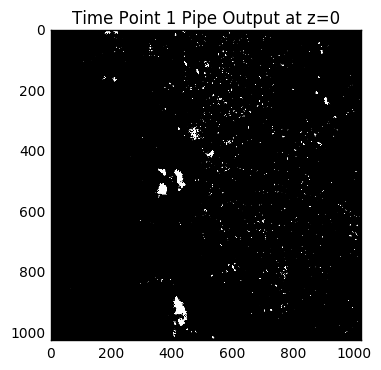

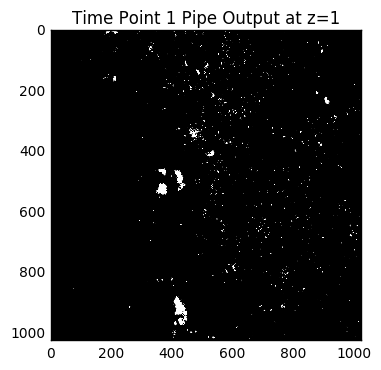

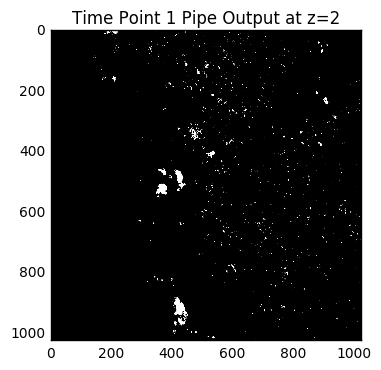

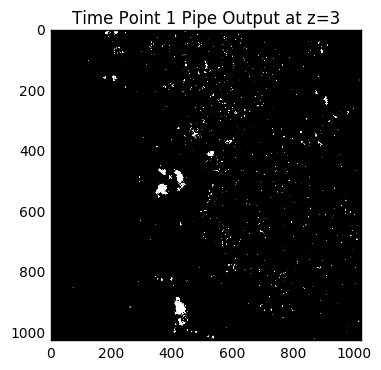

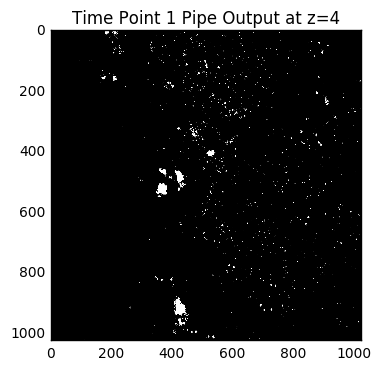

In [6]:
#Display the data to be used for testing
for i in range(tp1PostPipe.shape[0]):
    fig = plt.figure()
    plt.title('Time Point 1 Pipe Output at z='+str(i))
    plt.imshow(tp1PostPipe[i], cmap='gray')
    plt.show()

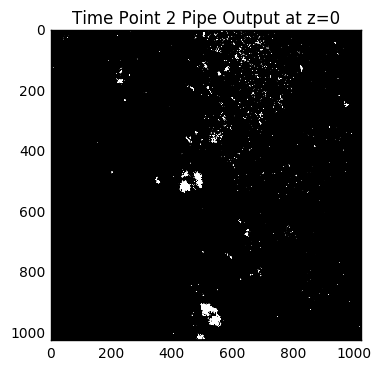

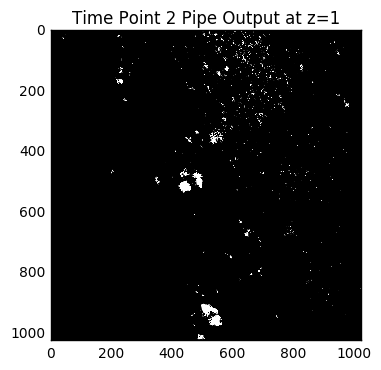

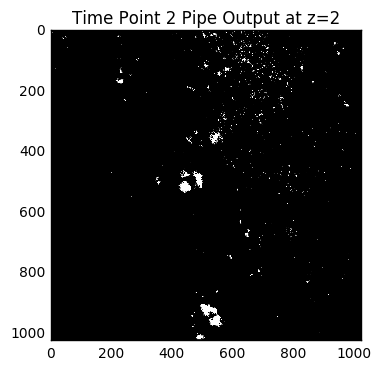

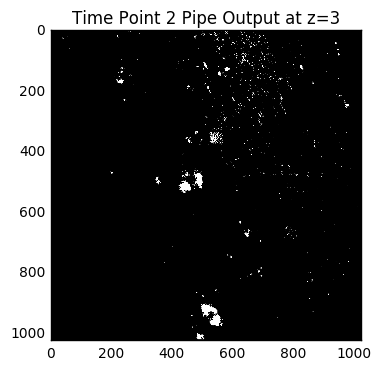

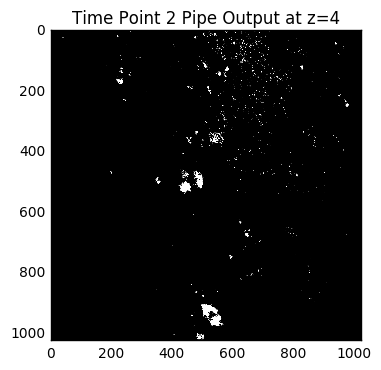

In [7]:
#Display the data to be used for testing
for i in range(tp2PostPipe.shape[0]):
    fig = plt.figure()
    plt.title('Time Point 2 Pipe Output at z='+str(i))
    plt.imshow(tp2PostPipe[i], cmap='gray')
    plt.show()

In [8]:
transform1 = hype.get3DRigid(pitch=0., yaw=0., roll=0., xT=5., yT=0., zT=0.)
transformVolume1 = hype.apply3DRigid(tp1PostPipe, transform1, True)

transform2 = hype.get3DRigid(pitch=0., yaw=.15, roll=0., xT=0., yT=0., zT=0.)
transformVolume2 = hype.apply3DRigid(tp1PostPipe, transform2, True)

transform3 = hype.get3DRigid(pitch=0., yaw=.15, roll=0., xT=5., yT=0., zT=0.)
transformVolume3 = hype.apply3DRigid(tp1PostPipe, transform3, True)

../code/functions/hyperReg.py:109: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



Out of bounds fraction:  0.0048828125
Non-0 Out of bounds fraction:  0.00487480163574
Out of bounds fraction:  0.0323238372803
Non-0 Out of bounds fraction:  0.0322603225708
Out of bounds fraction:  0.0346908569336
Non-0 Out of bounds fraction:  0.0346248626709


In [9]:
#get the cluster lists from both the base and the transformations
valDatA = cLib.thresholdByVolumeNaive(cLib.connectedComponents(tp1PostPipe), lowerLimit = 0, upperLimit = 50)
valDat1B = cLib.thresholdByVolumeNaive(cLib.connectedComponents(transformVolume1), lowerLimit = 0, upperLimit = 50)
valDat2B = cLib.thresholdByVolumeNaive(cLib.connectedComponents(transformVolume2), lowerLimit = 0, upperLimit = 50)
valDat3B = cLib.thresholdByVolumeNaive(cLib.connectedComponents(transformVolume3), lowerLimit = 0, upperLimit = 50)

Perfect Matching:


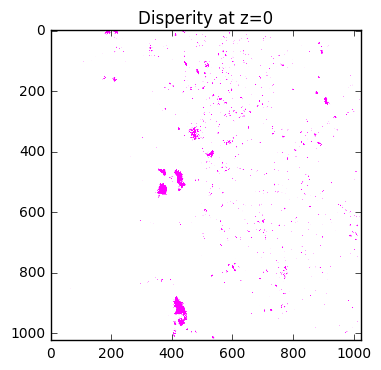

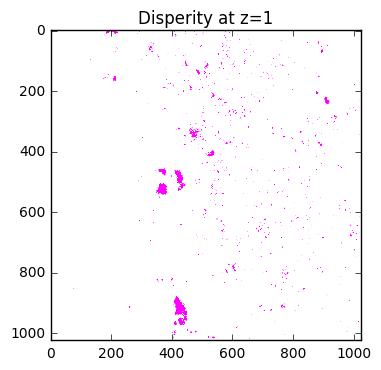

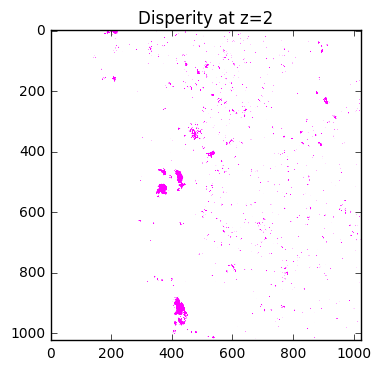

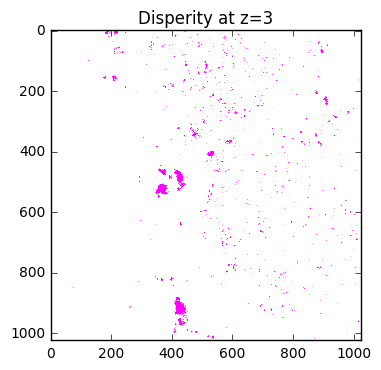

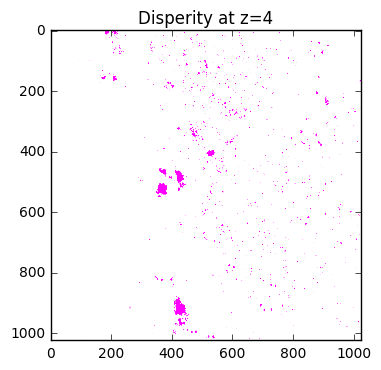



Slight Translation:


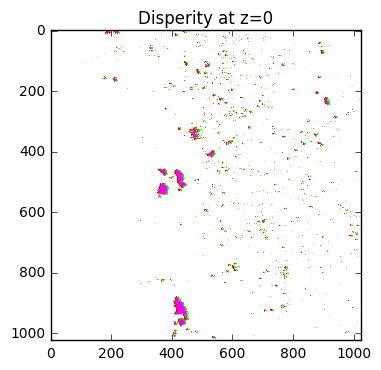

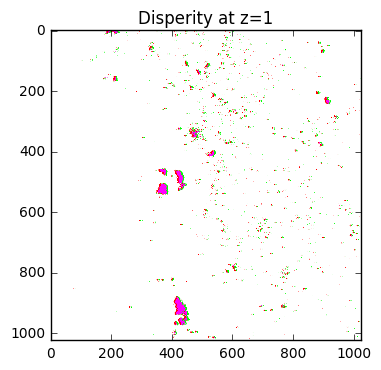

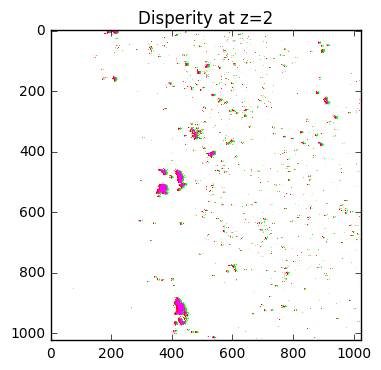

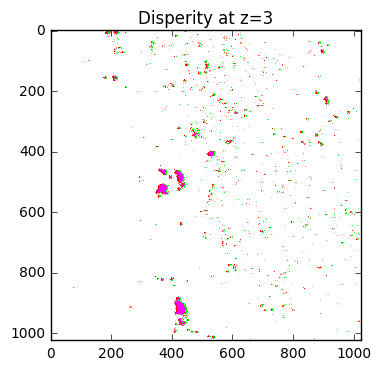

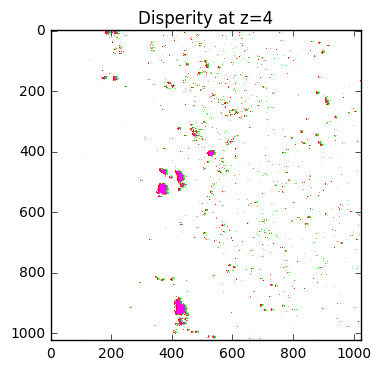



Slight Rotation:


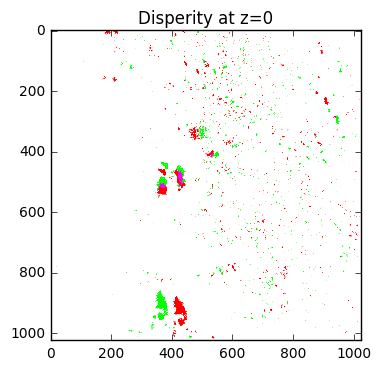

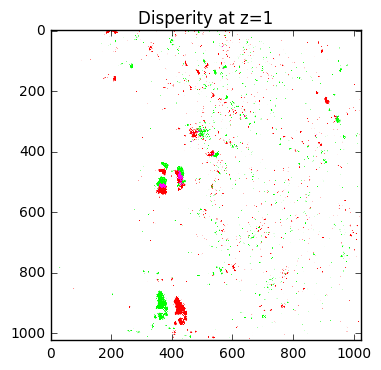

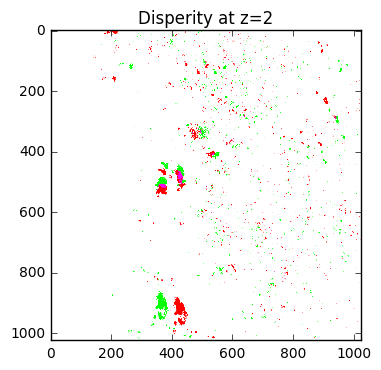

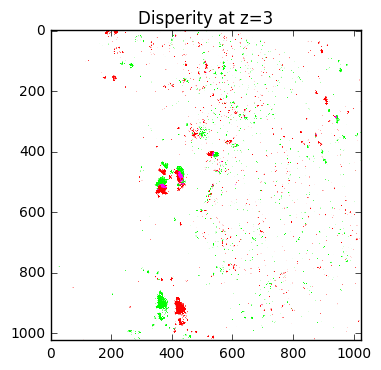

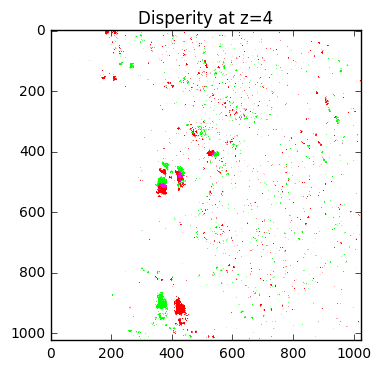



Slight Rigid:


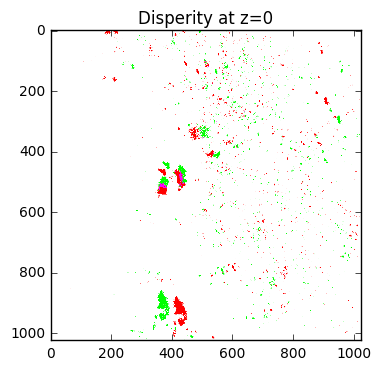

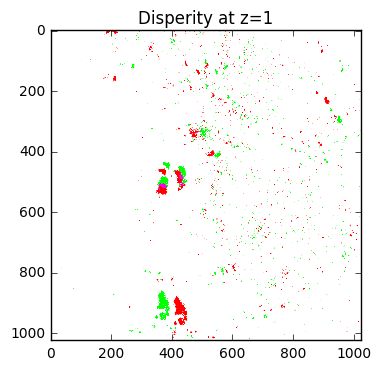

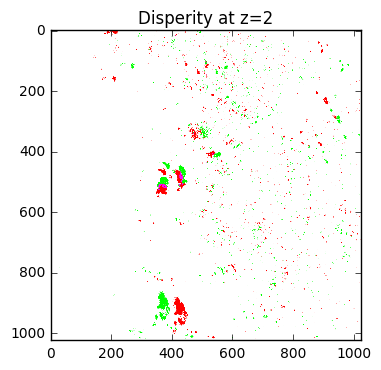

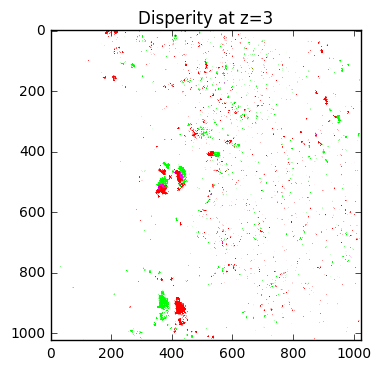

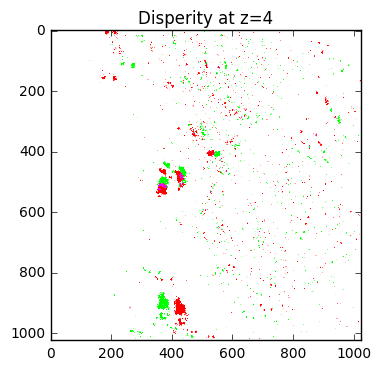

In [10]:
#Display the base data
print 'Perfect Matching:'
visVolDiff(tp1PostPipe, tp1PostPipe)
print '\n\nSlight Translation:'
visVolDiff(tp1PostPipe, transformVolume1)
print '\n\nSlight Rotation:'
visVolDiff(tp1PostPipe, transformVolume2)
print '\n\nSlight Rigid:'
visVolDiff(tp1PostPipe, transformVolume3)

# 1. The Simplest Approach
## A. Pseudocode
**INPUT SPACE:** Two lists of data type Cluster, which may or may not be the same size

**OUTPUT SPACE:** A pairing between all elements in list 1 and some or all elements in list 2. This pairing is neither guaranteed to be one-to-one or onto

In [ ]:
####################################
###THIS IS PSEUDOCODE; DO NOT RUN###
####################################

def simpleRegister(clusters1, clusters2):
    for cluster in clusters1:
        find pair in clusters2 minimizing l2 norm of centroids
        pair the current cluster in its pair
        remove the pair from cluster 2

## B. Algorithm Code

In [11]:
def simpleRegister(clusters1, clusters2, verbose=False):
    pairings = []
    this = len(clusters1)
    for clusterIdx in range(len(clusters1)):
        if verbose:
            print 'Progress: ', clusterIdx/float(this)
        lossList = [np.sum(abs(np.array(clusters1[clusterIdx].centroid) - np.array(elem.centroid))) for elem in clusters2]
        pairings.append((clusterIdx, np.argmin(lossList)))
    return pairings

## C. Functionality Tests
### I. Standard Tests

In [12]:
ftest1 = simpleRegister(funcDat1A, funcDat1B)
ftest2 = simpleRegister(funcDat2A, funcDat2B)

In [13]:
print 'Test1:', ftest1 == funcDat1Sol
print '\tExpected: ', funcDat1Sol
print '\tReturned:', ftest1
print '\n'

print 'Test2:', ftest2 == funcDat2Sol
print '\tExpected: ', funcDat2Sol
print '\tReturned:', ftest2
print '\n'

Test1: True
	Expected:  [(0, 0), (1, 1)]
	Returned: [(0, 0), (1, 1)]


Test2: False
	Expected:  [(0, 0), (1, 1)]
	Returned: [(0, 0), (1, 0)]




### II. Analysis
- The algorithm performed as expected on the first functionality test
- Since the algorithm does not guarantee a one-to-one function, it mapped both transform clusters to the same base cluster in test 2. Herein lies the fundamental error in using a simple l2 based loss metric

## D. Validation Tests

In [14]:
#comparison test
test0 = simpleRegister(valDatA, valDatA)

In [15]:
test1 = simpleRegister(valDatA, valDat1B)
test2 = simpleRegister(valDatA, valDat2B)
test3 = simpleRegister(valDatA, valDat3B)

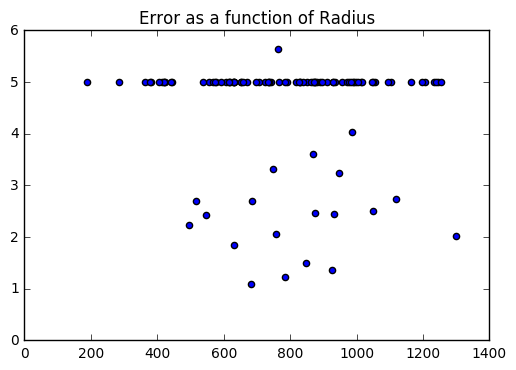

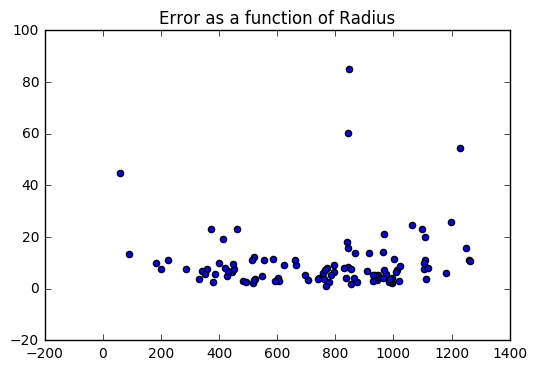

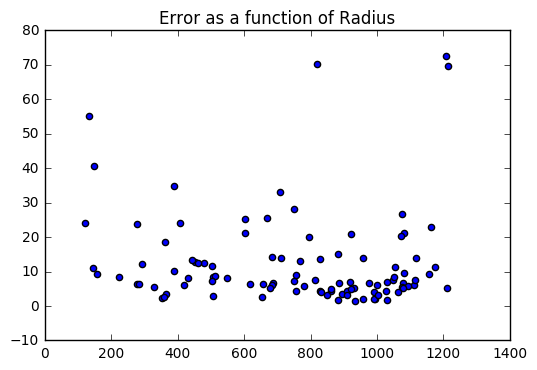

In [48]:
visReg(valDatA, valDat1B, test1, 'Test 1 Registration Visualization', tp1PostPipe)
visReg(valDatA, valDat2B, test2, 'Test 2 Registration Visualization', tp1PostPipe)
visReg(valDatA, valDat3B, test3, 'Test 3 Registration Visualization', tp1PostPipe)

## E. True Data Test

In [45]:
truDatA = valDatA
truDatB = cLib.thresholdByVolumeNaive(cLib.connectedComponents(tp2PostPipe), lowerLimit = 0, upperLimit = 50)

In [46]:
truTest = simpleRegister(truDatA, truDatB)

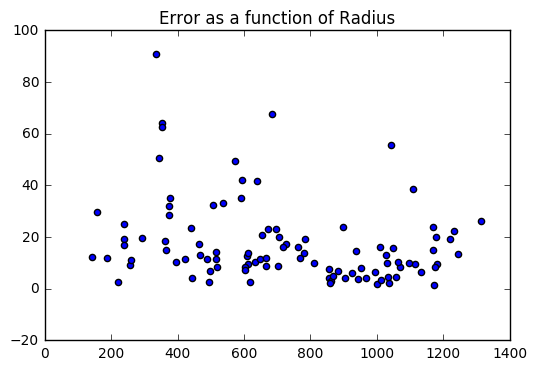

In [47]:
visReg(truDatA, truDatB, truTest, 'True Data Registration', tp1PostPipe)